# Day 1 Import everything

In [1226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
import qgrid

In [1227]:
df=pd.read_csv('data\Data_Marketing_Customer_Analysis_Round3 latest.csv')

In [1228]:

qgrid.show_grid(df,grid_options={'forceFitColumns': False})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## Check multicollinearity

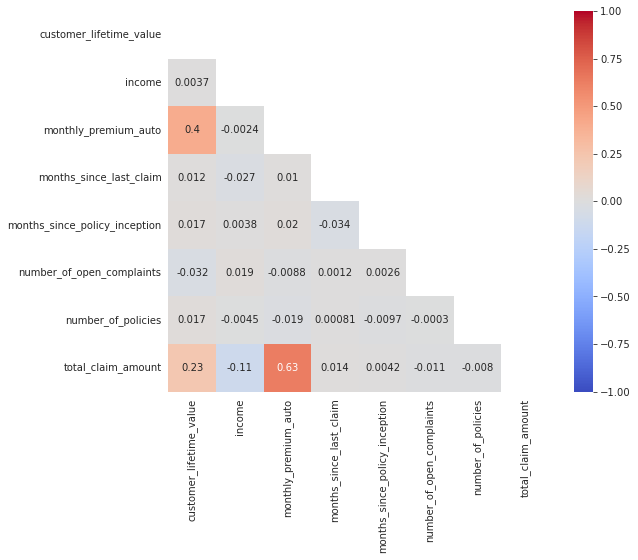

In [1229]:
#check if there are highly correlated features and drop them if there are any.
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Hot Label Encode Variables

In [1230]:
#Gather categorical variable column names
categoricals=df.select_dtypes(object)




### Re-code effective to date

In [1231]:
#Re-code effective_to_date
#categoricals.loc[categoricals['effective_to_date'].str.contains("1/"),'effective_to_date']="January"
#categoricals.loc[categoricals['effective_to_date'].str.contains("2/"),'effective_to_date']="February"
#col_list=categoricals.columns

In [1232]:
#Use get dummies to recode all categorical variables
def hot_code(categoricals):
    #Re-code effective_to_date
    categoricals.loc[categoricals['effective_to_date'].str.contains("1/"),'effective_to_date']="January"
    categoricals.loc[categoricals['effective_to_date'].str.contains("2/"),'effective_to_date']="February"
    col_list=categoricals.columns

    categoricals=pd.get_dummies(data=categoricals,columns=col_list, 
                                drop_first=True
                               )
    return categoricals

## Prepare numerical data

In [1233]:
#get numericals
numericals=df._get_numeric_data()
numericals

customer_lifetime_value  income  monthly_premium_auto  \
0                         4809   48029                    61   
1                         2228   92260                    64   
2                        14947   22139                   100   
3                        22332   49078                    97   
4                         9025   23675                   117   
...                        ...     ...                   ...   
10684                    15563   61541                   253   
10685                     5259   61146                    65   
10686                    23893   39837                   201   
10687                    11971   64195                   158   
10688                     6857   68942                   101   

       months_since_last_claim  months_since_policy_inception  \
0                            7                             52   
1                            3                             26   
2                           34                             31   
3                           10                              3   
4                           33                             31   
...                        ...                            ...   
10684                       12                             40   
10685                        7                             68   
10686                       11                             63   
10687                        0                             27   
10688                       31                              1   

       number_of_open_complaints  number_of_policies  total_claim_amount  
0                              0                   9                 292  
1                              0                   1                 744  
2                              0                   2                 480  
3                              0                   2                 484  
4                              0                   7                 707  
...                          ...                 ...                 ...  
10684                          0                   7                1214  
10685                          0                   6                 273  
10686                          0                   2                 381  
10687                          4                   6                 618  
10688                          0                   3                1021  

[10689 rows x 8 columns]

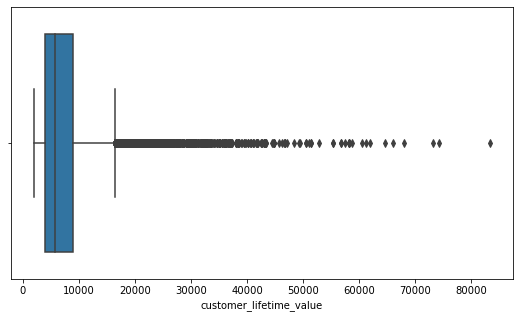

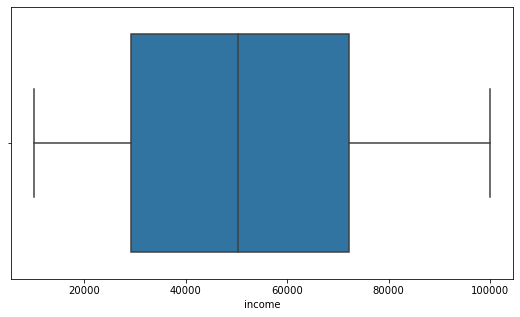

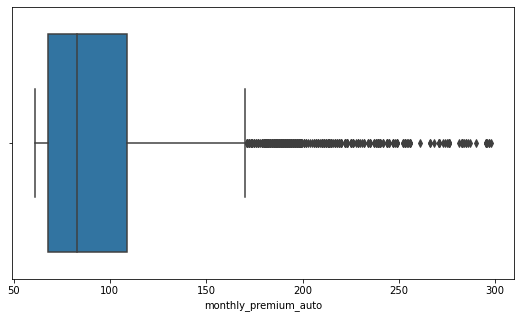

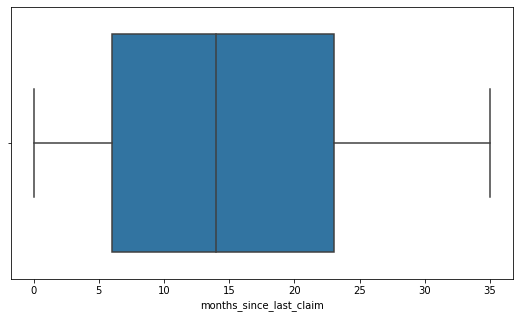

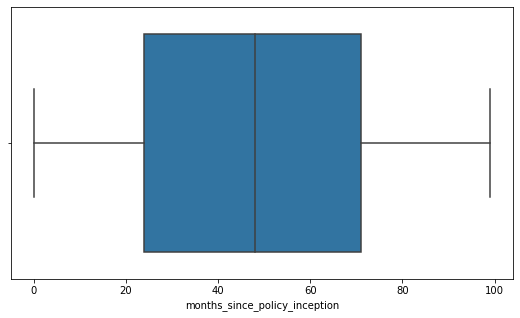

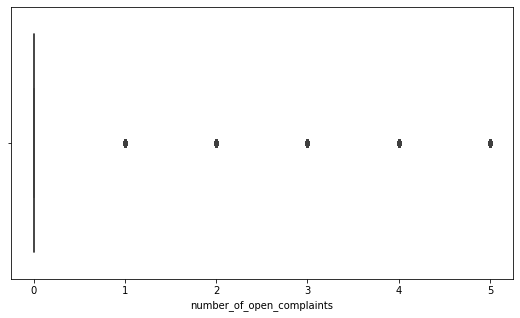

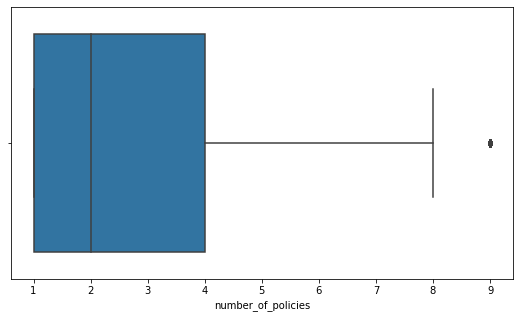

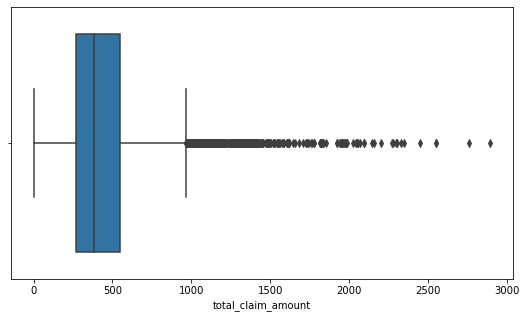

In [1234]:
x=numericals.columns
for i in x:
    plt.figure(figsize=(9,5))
    sns.boxplot(x=i,data=numericals) 

array([[<AxesSubplot:title={'center':'customer_lifetime_value'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly_premium_auto'}>],
       [<AxesSubplot:title={'center':'months_since_last_claim'}>,
        <AxesSubplot:title={'center':'months_since_policy_inception'}>,
        <AxesSubplot:title={'center':'number_of_open_complaints'}>],
       [<AxesSubplot:title={'center':'number_of_policies'}>,
        <AxesSubplot:title={'center':'total_claim_amount'}>,
        <AxesSubplot:>]], dtype=object)

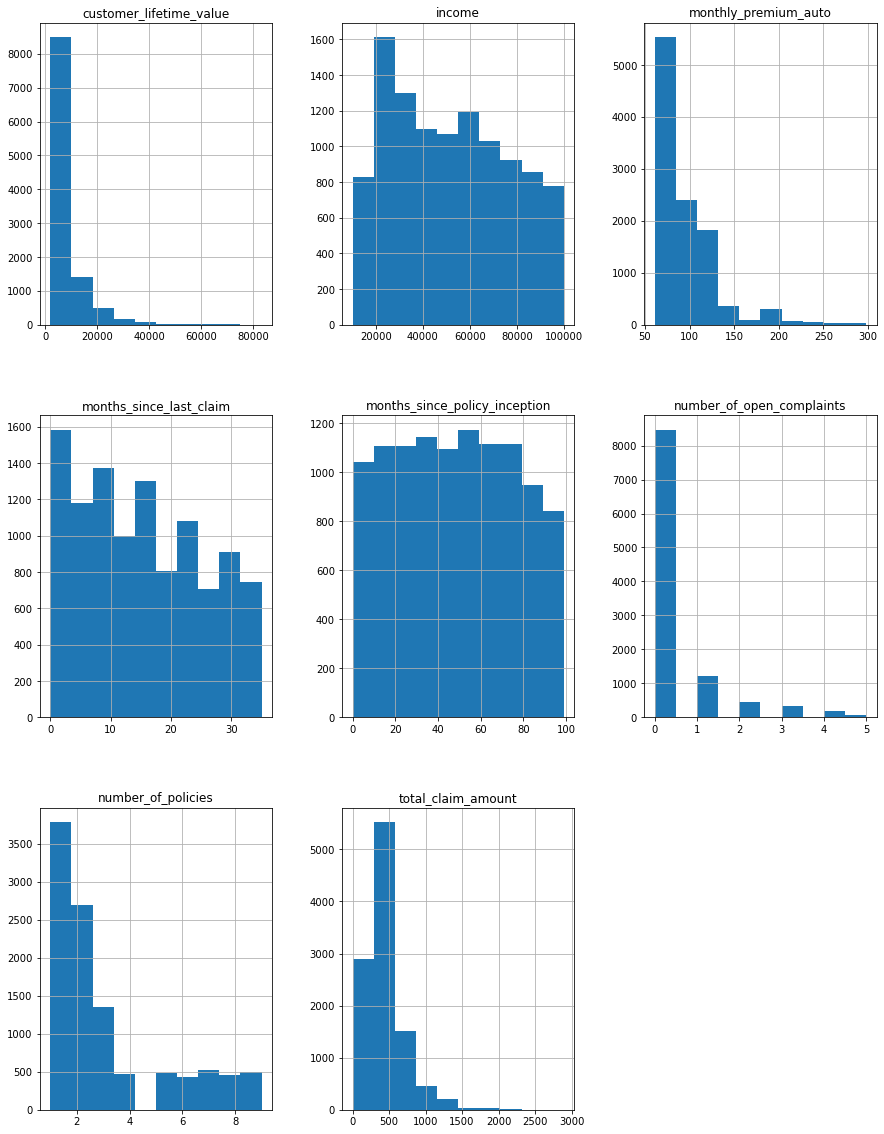

In [1235]:
numericals.hist(figsize=(15,20))

## Try model with all variables included - ALTERNATIVE

In [1236]:
#Can turn this off if you want only numericals
df_new=pd.concat([numericals,categoricals],axis=1)

## Remove outliers

In [1237]:
#Remove outliers
def remove_outliers(df,col_list):
    '''Removes outliers from dataframe DF using the 
    IQR * 1.5 rule.  
    Applies only to the columns in list COL_LIST'''
    
    for i in col_list:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)


        df.drop(df[ (df[i] > upper_bound) | (df[i] < lower_bound) ].index , inplace=True)

        return(df)


    
col_list=['number_of_policies','customer_lifetime_value','monthly_premium_auto']
#remove_outliers(numericals,col_list)
#numericals

remove_outliers(df_new,col_list)
df_new

customer_lifetime_value  income  monthly_premium_auto  \
1                         2228   92260                    64   
2                        14947   22139                   100   
3                        22332   49078                    97   
4                         9025   23675                   117   
5                         4745   50549                    61   
...                        ...     ...                   ...   
10684                    15563   61541                   253   
10685                     5259   61146                    65   
10686                    23893   39837                   201   
10687                    11971   64195                   158   
10688                     6857   68942                   101   

       months_since_last_claim  months_since_policy_inception  \
1                            3                             26   
2                           34                             31   
3                           10                              3   
4                           33                             31   
5                            2                             73   
...                        ...                            ...   
10684                       12                             40   
10685                        7                             68   
10686                       11                             63   
10687                        0                             27   
10688                       31                              1   

       number_of_open_complaints  number_of_policies  total_claim_amount  \
1                              0                   1                 744   
2                              0                   2                 480   
3                              0                   2                 484   
4                              0                   7                 707   
5                              0                   7                 292   
...                          ...                 ...                 ...   
10684                          0                   7                1214   
10685                          0                   6                 273   
10686                          0                   2                 381   
10687                          4                   6                 618   
10688                          0                   3                1021   

            region response  ... employment_status gender location_code  \
1      west region       no  ...        unemployed      f      suburban   
2             east       no  ...          employed      m      suburban   
3       north west      yes  ...          employed      m      suburban   
4       north west       no  ...     medical leave      f      suburban   
5      west region      yes  ...          employed      m      suburban   
...            ...      ...  ...               ...    ...           ...   
10684      central       no  ...        unemployed      f      suburban   
10685   north west       no  ...          employed      f         urban   
10686      central       no  ...          employed      f         rural   
10687  west region       no  ...          employed      f         urban   
10688      central       no  ...        unemployed      m      suburban   

      marital_status     policy_type        policy renew_offer_type  \
1             single   personal auto   personal l3           offer4   
2             single   personal auto   personal l3           offer3   
3             single  corporate auto  corporate l3           offer2   
4            married   personal auto   personal l2           offer1   
5           divorced   personal auto   personal l3           offer1   
...              ...             ...           ...              ...   
10684        married   personal auto   personal l1           offer3   
10685        married   personal auto   personal l3           offer2   
1068

## Prep x-y

In [1238]:
#get independent variable
#y=numericals['total_claim_amount']
#y=df_new['total_claim_amount']
def create_y(df):
    y=df['total_claim_amount']
    return y

In [1239]:
#get dependent variable
def create_x(df):
    x=df.drop(labels='total_claim_amount',axis=1)
    return x

# Day 2

## Train-test split.


In [1240]:
def train_test(x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.30,random_state=123)
    return x_train,x_test,y_train,y_test

## Standardize the data (after the data split).


In [1241]:
def scaler(x_train,x_test):
    std_scaler=StandardScaler().fit(x_train)
    x_train_scaled=std_scaler.transform(x_train)
    x_test_scaled=std_scaler.transform(x_test)
    #model=sm_OLS(x_train_scaled, x_test_scaled)
    #return model
    return x_train_scaled,x_test_scaled

## Apply linear regression.


### Using SciKitLearn

In [1242]:
#model=LinearRegression()
#model.fit(x_train_scaled, y_train)
#y_pred_test=model.predict(x_test_scaled)

In [1243]:
#r2_score(y_test,y_pred_test)

### using StatsModels

In [1244]:
def sm_OLS(x_train_scaled,x_test_scaled,y_train):
    x_train_const_scaled = sm.add_constant(x_train_scaled) # adding a constant so that formula understands y=mx+b that b<>0
    model = sm.OLS(y_train, x_train_const_scaled).fit()
    y_pred_train = model.predict(x_train_const_scaled) 

    x_test_const_scaled = sm.add_constant(x_test_scaled) # adding a constant
    y_pred_test = model.predict(x_test_const_scaled) 
    print(model.summary())
    return model

#### Check Plot

ValueError: x and y must have same first dimension, but have shapes (3059,) and (2767,)

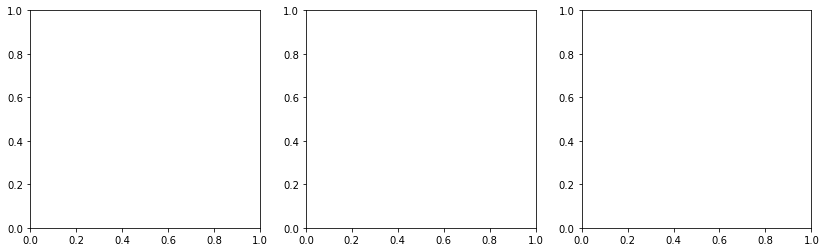

In [1245]:
# Make an scatter plot y_pred vs y. Should be close to a straight line
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred_test, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred_test)
ax[1].set_xlabel("Test y-y_pred_test")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred_test,y_test - y_pred_test,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred_test,np.zeros(len(y_pred_test)),linestyle='dashed')

#### R-squared

In [ ]:
model.rsquared_adj

In [ ]:
result=pd.DataFrame({"y_test":y_test,"y_pred_test":y_pred_test})

sns.regplot(x='y_pred_test',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

#### Check plot

# Day 3

## MSE.


In [ ]:
mse(y_train,y_pred_train)

## RMSE.


In [ ]:
rmse=math.sqrt(mse(y_train,y_pred_train))
rmse

## MAE.


In [ ]:
mae(y_train,y_pred_train)

## R2.


In [ ]:
model.rsquared

## Adjusted R2.


In [ ]:
model.rsquared_adj

### Using SciKitLearn

In [ ]:
r2_score(y_test,y_pred_test)

# Main Code Starts Here

In [ ]:
def col_transformer(x,y): 
    #create selectors
    from sklearn.compose import make_column_selector as selector

    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(x)
    categorical_columns = categorical_columns_selector(x)

    from sklearn.preprocessing import OneHotEncoder, StandardScaler

    categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()

    from sklearn.compose import ColumnTransformer

    preprocessor = ColumnTransformer([
        ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])
    return preprocessor

In [1246]:
col_list=['number_of_policies','customer_lifetime_value','monthly_premium_auto']

#remove outliers
remove_outliers(df,col_list)

#create x-y
y=create_y(df)
x=create_x(df)

#create ColumnTransformer
#preprocessor=col_transformer(x,y)
x_train,x_test,y_train,y_test=train_test(x,y)

from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(x)
categorical_columns = categorical_columns_selector(x)

from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
('standard_scaler', numerical_preprocessor, numerical_columns)])



x_train_scaled=preprocessor.fit_transform(x_train)
x_train_scaled

<6455x124 sparse matrix of type '<class 'numpy.float64'>'
	with 148465 stored elements in Compressed Sparse Row format>

## Get outputs

In [1075]:
y=create_y(df_new)
x=create_x(df_new)
x_train,x_test,y_train,y_test=train_test(x,y)
x_train_scaled,x_test_scaled=scaler(x_train,x_test)
model=sm_OLS(x_train_scaled,x_test_scaled,y_train)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     441.5
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:14:24   Log-Likelihood:                -40994.
No. Observations:                6455   AIC:                         8.209e+04
Df Residuals:                    6405   BIC:                         8.243e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        433.5741      1.732    250.296      0.0

### Model Summary

In [996]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     441.5
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:31:07   Log-Likelihood:                -40994.
No. Observations:                6455   AIC:                         8.209e+04
Df Residuals:                    6405   BIC:                         8.243e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        433.5741      1.732    250.296      0.0

### All coefficients sortable

In [997]:
attributes=["intercept"]
attributes.extend(x_train.columns)
parameters=pd.DataFrame(data={'Attribute': attributes, 'Coefficient':model.params, 'P-value':round(model.pvalues,4)})
qgrid.show_grid(parameters,grid_options={'forceFitColumns': False})


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

### Coefficients in importance Order

In [998]:
coefficients=model.params
features_importance = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': abs(coefficients[1:]),
    'Coefficient': coefficients[1:], 'P-value': round(model.pvalues[1:],4)})
features_importance = features_importance.sort_values(by='Importance', ascending=False)

qgrid.show_grid(features_importance,grid_options={'forceFitColumns': False})



QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

### R2 adjusted

In [999]:
model.rsquared_adj

0.7698287101011979

# Remove non-significant features to run again

In [954]:
#Get list of all features, starting with intercept and then all column names
attributes=["intercept"]
attributes.extend(x_train.columns)

#Build boolean list of whether each is significant or not. Build a new list of significant features using that boolean list
non_significant=model.pvalues<=.05
significant_values=[i for (i, j) in zip(attributes, non_significant) if j]
significant_values



['intercept',
 'income',
 'monthly_premium_auto',
 'response_no',
 'response_yes',
 'education_college',
 'education_high school or below',
 'employment_status_disabled',
 'employment_status_employed',
 'employment_status_retired',
 'employment_status_unemployed',
 'gender_f',
 'gender_m',
 'location_code_rural',
 'location_code_suburban',
 'marital_status_divorced',
 'marital_status_married',
 'marital_status_single',
 'policy_special l1',
 'renew_offer_type_offer1',
 'renew_offer_type_offer2',
 'vehicle_class_luxury car',
 'vehicle_size_medsize',
 'vehicle_size_small']

In [955]:
df_sig_only=df_new.copy()

all_col=df_new.columns
for i in all_col:
    if i not in significant_values:
        df_sig_only.drop(labels=i,axis=1,inplace=True)
df_sig_only['total_claim_amount']=df_new['total_claim_amount']
df_sig_only

income  monthly_premium_auto  response_no  response_yes  \
1       92260                    64            1             0   
2       22139                   100            1             0   
3       49078                    97            0             1   
4       23675                   117            1             0   
5       50549                    61            0             1   
...       ...                   ...          ...           ...   
10684   61541                   253            1             0   
10685   61146                    65            1             0   
10686   39837                   201            1             0   
10687   64195                   158            1             0   
10688   68942                   101            1             0   

       education_college  education_high school or below  \
1                      1                               0   
2                      0                               0   
3                      1                               0   
4                      0                               0   
5                      0                               1   
...                  ...                             ...   
10684                  0                               0   
10685                  1                               0   
10686                  0                               0   
10687                  1                               0   
10688                  0                               0   

       employment_status_disabled  employment_status_employed  \
1                               0                           0   
2                               0                           1   
3                               0                           1   
4                               0                           0   
5                               0                           1   
...                           ...                         ...   
10684                           0                           0   
10685                           0                           1   
10686                           0                           1   
10687                           0                           1   
10688                           0                           0   

       employment_status_retired  employment_status_unemployed  ...  \
1                              0                             1  ...   
2                              0                             0  ...   
3                              0                             0  ...   
4                              0                             0  ...   
5                              0                             0  ...   
...                          ...                           ...  ...   
10684                          0                             1  ...   
10685                          0                             0  ...   
10686                          0                             0  ...   
10687                          0                             0  ...   
10688                          0                             1  ...   

       marital_status_divorced  marital_status_married  marital_status_single  \
1                            0                       0                      1   
2                            0                       0                      1   
3                            0                       0                      1   
4                            0                       1                      0   
5                            1                       0                      0   
...                        ...                     ...                    ...   
10684                        0                       1                      0   
10685                        0                       1                      0   
10686                        0                       1                      0   
10687                        1                   

## Re-run OLS and see results

In [956]:
y=create_y(df_sig_only)
x=create_x(df_sig_only)
x_train,x_test,y_train,y_test=train_test(x,y)
x_train_scaled,x_test_scaled=scaler(x_train,x_test)
model=sm_OLS(x_train_scaled,x_test_scaled,y_train)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     1233.
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:10:49   Log-Likelihood:                -45331.
No. Observations:                7137   AIC:                         9.070e+04
Df Residuals:                    7116   BIC:                         9.085e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        434.0104      1.645    263.874      0.0

## Coefficients in importance order

In [957]:
coefficients=model.params
features_importance = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': abs(coefficients[1:]),
    'Coefficient': coefficients[1:], 'P-value': round(model.pvalues[1:],4)})
features_importance = features_importance.sort_values(by='Importance', ascending=False)

qgrid.show_grid(features_importance,grid_options={'forceFitColumns': False})



QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## New R2 adjusted

In [959]:
model.rsquared_adj

0.7753973698401512

In [1008]:
len(x_train.columns)

51

In [1034]:
x_train_scaled.shape

(6455, 51)

customer_lifetime_value    income  monthly_premium_auto  \
0                    3.013768 -0.362409              0.283816   
1                   -0.576452 -1.043432              0.283816   
2                   -0.582206  1.884337              0.283816   
3                    0.668919  0.831965              0.925857   
4                    1.842371  0.438639              2.618509   
...                       ...       ...                   ...   
6450                -0.440970  0.388236             -0.708428   
6451                 1.358798  0.252315              0.634020   
6452                -0.834404  0.510735             -0.941897   
6453                 2.420056  0.792754              3.523202   
6454                 3.986667  0.078765              0.634020   

      months_since_last_claim  months_since_policy_inception  \
0                   -0.611956                       0.845968   
1                   -0.908464                      -1.011809   
2                   -0.710792                      -0.475912   
3                   -0.908464                       0.452976   
4                   -0.809628                       0.953147   
...                       ...                            ...   
6450                -1.303808                       0.988874   
6451                -1.402644                       0.452976   
6452                 0.277568                      -0.797451   
6453                -0.710792                       1.453318   
6454                -0.018940                       0.417250   

      number_of_open_complaints  number_of_policies  region_east  \
0                     -0.424066           -0.135679    -0.305494   
1                     -0.424066           -0.851207     3.273387   
2                     -0.424066           -0.851207    -0.305494   
3                     -0.424066           -0.135679    -0.305494   
4                     -0.424066           -0.135679    -0.305494   
...                         ...                 ...          ...   
6450                  -0.424066            0.579849    -0.305494   
6451                  -0.424066           -0.135679     3.273387   
6452                  -0.424066           -0.851207     3.273387   
6453                   0.673067           -0.135679    -0.305494   
6454                  -0.424066           -0.135679    -0.305494   

      region_north west  region_west region  ...  sales_channel_branch  \
0             -0.627828           -0.716329  ...             -0.612503   
1             -0.627828           -0.716329  ...             -0.612503   
2             -0.627828           -0.716329  ...             -0.612503   
3              1.592792           -0.716329  ...             -0.612503   
4             -0.627828            1.396007  ...             -0.612503   
...                 ...                 ...  ...                   ...   
6450          -0.627828           -0.716329  ...             -0.612503   
6451          -0.627828           -0.716329  ...             -0.612503   
6452          -0.627828           -0.716329  ...             -0.612503   
6453           1.592792           -0.716329  ...              1.632645   
6454          -0.627828            1.396007  ...             -0.612503   

      sales_channel_call center  sales_channel_web  vehicle_class_luxury car  \
0                     -0.497336           2.408713                 -0.135275   
1                     -0.497336           2.408713                 -0.135275   
2                     -0.497336           2.408713                 -0.135275   
3                     -0.497336          -0.415160                 -0.135275   
4                     -0.497336          -0.415160                 -0.135275   
...                         ...                ...                       ...   
6450                  -0.497336          -0.415160                 -0.135275   
6451                  -0.497336           2.408713                 -0.135275   
6452                  -0.49733